In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [138]:
frame = pd.read_csv('for_data_science_newline_fixed.csv', usecols = ["IN FILE","CLIP LENGTH","OFFSET","DURATION","MAX FREQ","MIN FREQ","SAMPLE RATE","LAST MOD BY"])
# frame.head(10)

In [139]:
CLIP_LENGTHS = frame.groupby("IN FILE")[["CLIP LENGTH"]].max()
SUM_DURATIONS = frame.groupby("IN FILE")[["DURATION"]].sum()

MEDIAN_DURATIONS = frame.groupby("IN FILE")[["DURATION"]].median()
MEDIAN_DURATIONS = MEDIAN_DURATIONS.rename(columns={'DURATION': 'MEDIAN DURATION'})

NUMBER_ANN = frame.groupby("IN FILE")[["OFFSET"]].count()
NUMBER_ANN = NUMBER_ANN.rename(columns = {'OFFSET':'OFFSET COUNT'})

MED_DIST_BW_ANNS = frame.copy(True)

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS.sort_values(['IN FILE','OFFSET'])
MED_DIST_BW_ANNS['ENDSET'] = MED_DIST_BW_ANNS['OFFSET'] + MED_DIST_BW_ANNS['DURATION']

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS[['IN FILE','CLIP LENGTH','OFFSET','ENDSET','LAST MOD BY']]

MED_DIST_BW_ANNS['PREV END'] = MED_DIST_BW_ANNS.loc[MED_DIST_BW_ANNS['IN FILE'].shift(-1) == MED_DIST_BW_ANNS['IN FILE'], 'ENDSET']
MED_DIST_BW_ANNS['PREV END'] = MED_DIST_BW_ANNS['PREV END'].shift()

MED_DIST_BW_ANNS = MED_DIST_BW_ANNS.fillna(0)
MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'] = MED_DIST_BW_ANNS['OFFSET'] - MED_DIST_BW_ANNS['PREV END']

MED_DIST_BW_ANNS['OVERLAP'] = MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'].loc[MED_DIST_BW_ANNS['DIST BETWEEN ANN PREV'] < 0]

OVER_LAP = MED_DIST_BW_ANNS.groupby('IN FILE')[['OVERLAP']].count()
OVER_LAP = OVER_LAP.rename(columns = {'OVERLAP':'OVERLAP COUNT'})

DIST_BETWEEN_ANN_PREV = MED_DIST_BW_ANNS.groupby('IN FILE')[['DIST BETWEEN ANN PREV']].median()
DIST_BETWEEN_ANN_PREV = DIST_BETWEEN_ANN_PREV.rename(columns={'DIST BETWEEN ANN PREV': 'MEDIAN DIST B/W ANNS'})

LAST_MOD_BY = MED_DIST_BW_ANNS.groupby('IN FILE')[['LAST MOD BY']].max()

WHITE_SPACE = frame.copy(True)
DUR = WHITE_SPACE.groupby(['IN FILE'])[['DURATION']].sum()
DUR = DUR.rename(columns = {'DURATION':'SUM DURATION'})
LEN = WHITE_SPACE.groupby(['IN FILE'])[['CLIP LENGTH']].max()
WHITE_SPACE = LEN.join(DUR)
WHITE_SPACE['WHITE SPACE'] = WHITE_SPACE['CLIP LENGTH'] - WHITE_SPACE['SUM DURATION']

WHITE_SPACE = WHITE_SPACE.join(OVER_LAP)
WHITE_SPACE = WHITE_SPACE.join(DIST_BETWEEN_ANN_PREV)
WHITE_SPACE = WHITE_SPACE.join(MEDIAN_DURATIONS)
WHITE_SPACE = WHITE_SPACE.join(NUMBER_ANN)
WHITE_SPACE = WHITE_SPACE.join(LAST_MOD_BY)
WHITE_SPACE.reset_index(inplace=True)
# WHITE_SPACE.head(10)
# MED_DIST_BW_ANNS

In [140]:
def species(row):
    species = row['IN FILE']
    spec = species.split('-')
    spec_to = '-'.join(spec[:-2])
    return spec_to

WHITE_SPACE['Genus'] = WHITE_SPACE.apply(lambda row: species(row), axis=1)
len(WHITE_SPACE['Genus'].unique())
# WHITE_SPACE.head(10)

515

In [141]:
# resample if sampled is admin user
annotator = WHITE_SPACE['LAST MOD BY'].unique()
sampled_annotator = random.sample(list(annotator),1) #['kkong', 'JacobGlennAyers']  
# ['EdZamora'], ['kkong', 'sunqiaochen'], ['kkong', 'JacobGlennAyers'], ['kushagra1067', 'EdZamora'], ['hjagarla', 'alarce'], ['dnelson', 'sunqiaochen'], ['sunqiaochen', 'j4yang'](not gud), ['dnelson', 'hjagarla']
# ['weszhen', 'JacobGlennAyers', 'dnelson']
sampled_annotator 

['alarce']

In [142]:
annotator_df = WHITE_SPACE[WHITE_SPACE['LAST MOD BY'].isin(sampled_annotator)]
annotator_df.head()

,IN FILE,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,LAST MOD BY,Genus
0,Aburria-aburri-257423.wav,24.63350,8.7813,15.85220,0,2.36140,3.3205,3,alarce,Aburria
1,Aburria-aburri-387212.wav,84.48000,9.4200,75.06000,0,26.76000,3.1400,3,alarce,Aburria
2,Accipiter-bicolor-451839.wav,5.66857,4.6442,1.02437,3,0.00000,0.2155,20,alarce,Accipiter
3,Accipiter-collaris-260335.wav,45.37470,7.6708,37.70390,0,5.19555,1.0301,8,alarce,Accipiter
4,Accipiter-collaris-260336.wav,26.93220,4.8604,22.07180,1,1.03060,0.5701,8,alarce,Accipiter


In [143]:
genus = annotator_df['Genus'].value_counts()
sampled_genus = genus.index[:5]#random.sample(list(genus),1)
sampled_genus
# genus

Index(['Buteo', 'Amazona', 'Calidris', 'Accipiter', 'Tolmomyias'], dtype='object')

In [144]:
annotator_genus_df = annotator_df[annotator_df['Genus'].isin(sampled_genus)]
annotator_genus_df.head()
# annotator_genus_df.shape

,IN FILE,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,LAST MOD BY,Genus
2,Accipiter-bicolor-451839.wav,5.66857,4.6442,1.02437,3,0.00000,0.21550,20,alarce,Accipiter
3,Accipiter-collaris-260335.wav,45.37470,7.6708,37.70390,0,5.19555,1.03010,8,alarce,Accipiter
4,Accipiter-collaris-260336.wav,26.93220,4.8604,22.07180,1,1.03060,0.57010,8,alarce,Accipiter
5,Accipiter-poliogaster-121768.wav,121.75200,14.5203,107.23170,0,15.27025,2.35005,6,alarce,Accipiter
6,Accipiter-poliogaster-40546.wav,24.55510,7.4186,17.13650,1,0.00000,0.36990,7,alarce,Accipiter


In [145]:
# annotator_genus_df.iloc[:,2]
# annotator_genus_df.iloc[:,4]

In [146]:
X = annotator_genus_df.drop(columns = ['IN FILE','Genus','LAST MOD BY']) # expand to taxa rather than species

Y = np.array(annotator_genus_df['Genus'])
Y_2 = np.array(annotator_genus_df['LAST MOD BY'])
Y_3 = np.array(annotator_genus_df['IN FILE'])

In [147]:
# X

In [148]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std

array([[-9.55665792e-01, -5.29182660e-01, -9.14093085e-01,
         2.78164138e+00, -5.96464806e-01, -1.07452858e+00,
         1.02152615e+00],
       [ 7.91389610e-01, -1.84423677e-01,  1.04959859e+00,
        -4.50547548e-01,  1.25815556e+00,  2.10828995e-01,
        -3.24196922e-01],
       [-2.00737395e-02, -5.04555391e-01,  2.12711513e-01,
         6.26848762e-01, -2.28578490e-01, -5.15005136e-01,
        -3.24196922e-01],
       [ 4.15196327e+00,  5.95800551e-01,  4.77186990e+00,
        -4.50547548e-01,  4.85445312e+00,  2.29357847e+00,
        -5.48484101e-01],
       [-1.24665282e-01, -2.13151694e-01, -5.15069085e-02,
         6.26848762e-01, -5.96464806e-01, -8.30900773e-01,
        -4.36340512e-01],
       [-9.59114044e-01, -5.58070150e-01, -9.04711894e-01,
        -4.50547548e-01, -5.96464806e-01, -1.03326648e+00,
        -3.24196922e-01],
       [-1.04140217e+00, -1.01604394e+00, -7.89592474e-01,
        -4.50547548e-01, -2.74483963e-01, -1.12257564e+00,
        -9.9705845

In [149]:
pca = PCA()
pca.fit(X_std)

PCA()

In [150]:
pca.explained_variance_ratio_

array([4.54217133e-01, 2.77922249e-01, 1.24409822e-01, 9.72095684e-02,
       3.59181220e-02, 1.03231051e-02, 1.89335072e-33])

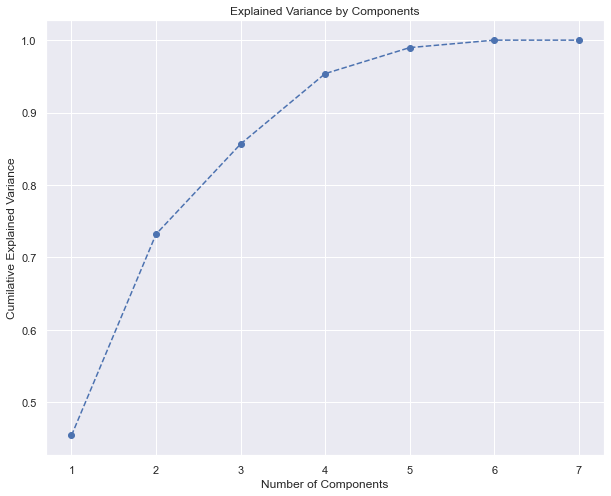

In [151]:
plt.figure(figsize = (10,8))
plt.plot(range(1,8),pca.explained_variance_ratio_.cumsum(),marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumilative Explained Variance')
plt.show()

In [152]:
pca = PCA(n_components= 3)

In [153]:
pca.fit(X_std)
# pca.components_

PCA(n_components=3)

In [154]:
X_standard = pd.DataFrame(X_std, columns = X.columns)
# X_standard

In [155]:
components = pd.DataFrame(pca.components_,columns = X_standard.columns,index = ['PC-1','PC-2','PC-3'])
components.T

,PC-1,PC-2,PC-3
CLIP LENGTH,0.534315,0.139438,-0.135110
SUM DURATION,0.313031,0.516284,0.391095
WHITE SPACE,0.503005,-0.072987,-0.348206
OVERLAP COUNT,-0.164525,0.389414,-0.603502
MEDIAN DIST B/W ANNS,0.407308,-0.323840,-0.373669
MEDIAN DURATION,0.408734,-0.104196,0.445492
OFFSET COUNT,0.058941,0.664310,-0.072360


In [156]:
pca.transform(X_std)
scores_pca = pca.transform(X_std)
scores_pca

array([[-2.2156498 ,  1.72719361, -1.76800729],
       [ 1.54672167, -0.88169777, -0.62537314],
       [-0.48751485, -0.12239754, -0.76754837],
       [ 7.76175174, -1.81260025, -2.47013912],
       [-0.87065465,  0.1103033 , -0.54259474],
       [-1.75249439, -0.44582363,  0.28428636],
       [-1.82693405, -1.2440979 , -0.03520474],
       [ 3.07086529,  1.90628285,  2.56885718],
       [ 3.11651963,  1.87273523,  2.60477475],
       [-1.29801623,  2.62108188, -1.30796834],
       [-0.39963031,  0.3367208 ,  0.52222957],
       [-1.40942975,  1.56145217, -1.64977368],
       [-0.62158318, -0.50526046,  0.82473498],
       [-1.65008441, -0.94153498,  0.22568123],
       [-0.21508926,  0.29640935,  0.13285889],
       [ 1.67531576, -0.8299975 ,  0.49242453],
       [ 0.22250964,  2.45281567,  0.07938199],
       [ 0.36745953,  3.00546112,  0.79191774],
       [-0.50942258, -0.67134764, -0.05096345],
       [-1.26475583,  1.40196131, -0.75249962],
       [-0.57570959,  0.4227497 ,  0.326

In [157]:
scores_components = pd.DataFrame(scores_pca,columns = ['PC-1','PC-2','PC-3'])
scores_components['IN FILE'],scores_components['LAST MOD BY'], scores_components['Genus'] = Y_3,Y_2, Y
scores_components

,PC-1,PC-2,PC-3,IN FILE,LAST MOD BY,Genus
0,-2.215650,1.727194,-1.768007,Accipiter-bicolor-451839.wav,alarce,Accipiter
1,1.546722,-0.881698,-0.625373,Accipiter-collaris-260335.wav,alarce,Accipiter
2,-0.487515,-0.122398,-0.767548,Accipiter-collaris-260336.wav,alarce,Accipiter
3,7.761752,-1.812600,-2.470139,Accipiter-poliogaster-121768.wav,alarce,Accipiter
4,-0.870655,0.110303,-0.542595,Accipiter-poliogaster-40546.wav,alarce,Accipiter
5,-1.752494,-0.445824,0.284286,Accipiter-striatus-481896.wav,alarce,Accipiter
6,-1.826934,-1.244098,-0.035205,Accipiter-striatus-497793.wav,alarce,Accipiter
7,3.070865,1.906283,2.568857,Accipiter-superciliosus-329800.wav,alarce,Accipiter
8,3.116520,1.872735,2.604775,Accipiter-superciliosus-427037.wav,alarce,Accipiter
9,-1.298016,2.621082,-1.307968,Amazona-aestiva-467090.wav,alarce,Amazona


In [158]:
# Within Cluster Sum of Squares
# Elbow Technique

wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

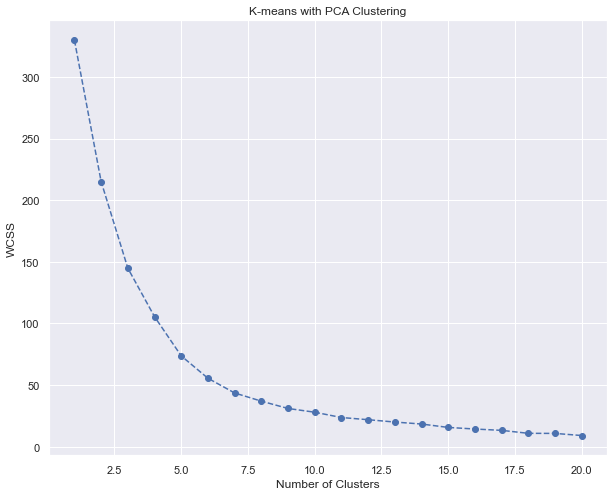

In [159]:
plt.figure(figsize = (10,8))
plt.plot(range(1,21),wcss,marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [160]:
kmeans_pca = KMeans(n_clusters = 5, init = 'k-means++',random_state = 42)

In [161]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=5, random_state=42)

In [162]:
df_segm_pca_kmeans = pd.concat([X.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-4:] = ['PCA1','PCA2','PCA3','PCA4']

df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [163]:
df_segm_pca_kmeans.head()

,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,PCA1,PCA2,PCA3,PCA4,Segment K-means PCA
0,5.66857,4.6442,1.02437,3,0.00000,0.21550,20,-2.215650,1.727194,-1.768007,2
1,45.37470,7.6708,37.70390,0,5.19555,1.03010,8,1.546722,-0.881698,-0.625373,0
2,26.93220,4.8604,22.07180,1,1.03060,0.57010,8,-0.487515,-0.122398,-0.767548,3
3,121.75200,14.5203,107.23170,0,15.27025,2.35005,6,7.761752,-1.812600,-2.470139,4
4,24.55510,7.4186,17.13650,1,0.00000,0.36990,7,-0.870655,0.110303,-0.542595,3


In [164]:
df_segm_pca_kmeans['Cluster'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'first',1:'second',2:'third',3:'fourth',4:'fifth'})
# df_segm_pca_kmeans

In [165]:
df_segm_pca_kmeans['IN FILE'],df_segm_pca_kmeans['LAST MOD BY'], df_segm_pca_kmeans['Genus'] = Y_3,Y_2, Y

In [166]:
df_segm_pca_kmeans

,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,PCA1,PCA2,PCA3,PCA4,Segment K-means PCA,Cluster,IN FILE,LAST MOD BY,Genus
0,5.66857,4.6442,1.02437,3,0.00000,0.21550,20,-2.215650,1.727194,-1.768007,2,third,Accipiter-bicolor-451839.wav,alarce,Accipiter
1,45.37470,7.6708,37.70390,0,5.19555,1.03010,8,1.546722,-0.881698,-0.625373,0,first,Accipiter-collaris-260335.wav,alarce,Accipiter
2,26.93220,4.8604,22.07180,1,1.03060,0.57010,8,-0.487515,-0.122398,-0.767548,3,fourth,Accipiter-collaris-260336.wav,alarce,Accipiter
3,121.75200,14.5203,107.23170,0,15.27025,2.35005,6,7.761752,-1.812600,-2.470139,4,fifth,Accipiter-poliogaster-121768.wav,alarce,Accipiter
4,24.55510,7.4186,17.13650,1,0.00000,0.36990,7,-0.870655,0.110303,-0.542595,3,fourth,Accipiter-poliogaster-40546.wav,alarce,Accipiter
5,5.59020,4.3906,1.19960,0,0.00000,0.24165,8,-1.752494,-0.445824,0.284286,3,fourth,Accipiter-striatus-481896.wav,alarce,Accipiter
6,3.72000,0.3701,3.34990,0,0.90200,0.18505,2,-1.826934,-1.244098,-0.035205,3,fourth,Accipiter-striatus-497793.wav,alarce,Accipiter
7,61.88410,39.3425,22.54160,0,0.90000,2.57020,15,3.070865,1.906283,2.568857,1,second,Accipiter-superciliosus-329800.wav,alarce,Accipiter
8,61.88410,38.9824,22.90170,0,0.88120,2.65010,15,3.116520,1.872735,2.604775,1,second,Accipiter-superciliosus-427037.wav,alarce,Accipiter
9,18.26400,14.3924,3.87160,3,0.00000,0.48035,24,-1.298016,2.621082,-1.307968,2,third,Amazona-aestiva-467090.wav,alarce,Amazona


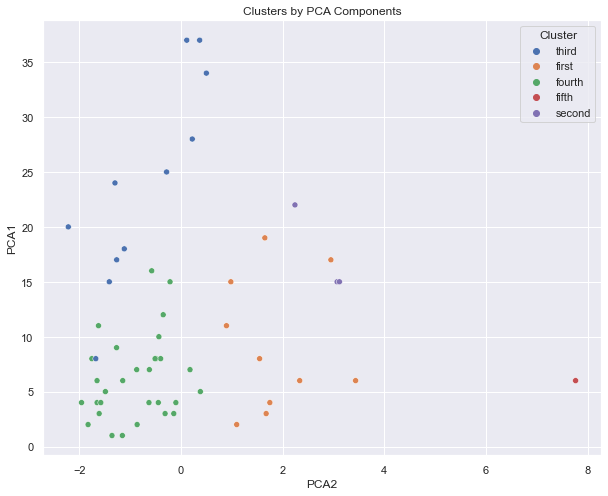

In [167]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df_segm_pca_kmeans,x = 'PCA2', y = 'PCA1', hue = df_segm_pca_kmeans['Cluster'])
plt.title('Clusters by PCA Components')
plt.show()

In [168]:
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np


fig = px.scatter_3d(df_segm_pca_kmeans, 
                    x="PCA1", 
                    y="PCA2", 
                    z='PCA3', 
                    color = df_segm_pca_kmeans['Cluster'],
                    hover_name = list(tuple(zip(df_segm_pca_kmeans['IN FILE'],df_segm_pca_kmeans['LAST MOD BY'])))) 


#color = Y, color_discrete_sequence= px.colors.qualitative.G10)


clust_1 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'first']
x, y, z = clust_1['PCA1'], clust_1['PCA2'], clust_1['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightblue', opacity=0.50)]).data[0])


clust_2 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'second']
x2, y2, z2 = clust_2['PCA1'], clust_2['PCA2'], clust_2['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x2, y=y2, z=z2, color='lightblue', opacity=0.50)]).data[0])


clust_3 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'third']
x3, y3, z3 = clust_3['PCA1'], clust_3['PCA2'], clust_3['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x3, y=y3, z=z3, color='lightblue', opacity=0.50)]).data[0])


clust_4 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'fourth']
x4, y4, z4 = clust_4['PCA1'], clust_4['PCA2'], clust_4['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x4, y=y4, z=z4, color='lightblue', opacity=0.50)]).data[0])


clust_5 = df_segm_pca_kmeans[df_segm_pca_kmeans['Cluster'] == 'fifth']
x5, y5, z5 = clust_5['PCA1'], clust_5['PCA2'], clust_5['PCA3']
fig.add_trace(go.Figure(data=[go.Mesh3d(x=x5, y=y5, z=z5, color='lightblue', opacity=0.50)]).data[0])


fig.update_layout(title_text= (' & '.join(df_segm_pca_kmeans['LAST MOD BY'].unique()) + ' Annotations'), title_x=0.5)
fig.show()

In [169]:
annotator_genus_df

,IN FILE,CLIP LENGTH,SUM DURATION,WHITE SPACE,OVERLAP COUNT,MEDIAN DIST B/W ANNS,MEDIAN DURATION,OFFSET COUNT,LAST MOD BY,Genus
2,Accipiter-bicolor-451839.wav,5.66857,4.6442,1.02437,3,0.00000,0.21550,20,alarce,Accipiter
3,Accipiter-collaris-260335.wav,45.37470,7.6708,37.70390,0,5.19555,1.03010,8,alarce,Accipiter
4,Accipiter-collaris-260336.wav,26.93220,4.8604,22.07180,1,1.03060,0.57010,8,alarce,Accipiter
5,Accipiter-poliogaster-121768.wav,121.75200,14.5203,107.23170,0,15.27025,2.35005,6,alarce,Accipiter
6,Accipiter-poliogaster-40546.wav,24.55510,7.4186,17.13650,1,0.00000,0.36990,7,alarce,Accipiter
7,Accipiter-striatus-481896.wav,5.59020,4.3906,1.19960,0,0.00000,0.24165,8,alarce,Accipiter
8,Accipiter-striatus-497793.wav,3.72000,0.3701,3.34990,0,0.90200,0.18505,2,alarce,Accipiter
9,Accipiter-superciliosus-329800.wav,61.88410,39.3425,22.54160,0,0.90000,2.57020,15,alarce,Accipiter
10,Accipiter-superciliosus-427037.wav,61.88410,38.9824,22.90170,0,0.88120,2.65010,15,alarce,Accipiter
46,Amazona-aestiva-467090.wav,18.26400,14.3924,3.87160,3,0.00000,0.48035,24,alarce,Amazona


In [170]:
kaleidoscope_format = pd.read_csv('for_data_science_newline_fixed.csv')
for_kaleidoscope = kaleidoscope_format[kaleidoscope_format['IN FILE'].isin(df_segm_pca_kmeans['IN FILE'].to_list())] 
for_kaleidoscope

,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,LAST MOD DATE,LAST MOD TIME
6,Accipiter-bicolor-451839.wav,5.66857,0.3605,0.4399,24000,0,44100,Accipiter bicolor Bicolored Hawk,921.847,alarce,11/22/2021,02:11:43
7,Accipiter-bicolor-451839.wav,5.66857,0.9982,0.2215,24000,0,44100,Accipiter bicolor Bicolored Hawk,921.849,alarce,11/22/2021,02:11:43
8,Accipiter-bicolor-451839.wav,5.66857,0.8004,0.1949,24000,0,44100,Accipiter bicolor Bicolored Hawk,921.848,alarce,11/22/2021,02:11:43
9,Accipiter-bicolor-451839.wav,5.66857,1.2049,0.3690,24000,0,44100,Accipiter bicolor Bicolored Hawk,921.850,alarce,11/22/2021,02:11:43
10,Accipiter-bicolor-451839.wav,5.66857,1.5857,0.2215,24000,0,44100,Accipiter bicolor Bicolored Hawk,921.850,alarce,11/22/2021,02:11:43
...,...,...,...,...,...,...,...,...,...,...,...,...
28515,Tolmomyias-sulphurescens-45232.wav,45.55760,31.5082,0.6500,24000,0,44100,Tolmomyias sulphurescens Yellow-olive Flatbill,755.540,alarce,11/18/2021,00:38:23
28516,Tolmomyias-sulphurescens-45232.wav,45.55760,23.4053,0.6400,24000,0,44100,Tolmomyias sulphurescens Yellow-olive Flatbill,755.539,alarce,11/18/2021,00:38:23
28517,Tolmomyias-sulphurescens-45232.wav,45.55760,44.4608,0.7100,24000,0,44100,Tolmomyias sulphurescens Yellow-olive Flatbill,755.545,alarce,11/18/2021,00:38:23
28518,Tolmomyias-sulphurescens-45232.wav,45.55760,36.2879,0.7400,24000,0,44100,Tolmomyias sulphurescens Yellow-olive Flatbill,755.542,alarce,11/18/2021,00:38:23
